<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#quick-test-of-EfficientDet0" data-toc-modified-id="quick-test-of-EfficientDet0-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>quick test of EfficientDet0</a></span><ul class="toc-item"><li><span><a href="#data" data-toc-modified-id="data-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>data</a></span></li><li><span><a href="#coco-labels" data-toc-modified-id="coco-labels-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>coco labels</a></span></li><li><span><a href="#model" data-toc-modified-id="model-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>model</a></span></li></ul></li><li><span><a href="#Sources" data-toc-modified-id="Sources-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Sources</a></span></li></ul></div>

# Car Detection
Research related to object detection using car detection dataset as an example.


In [80]:
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

## quick test of EfficientDet0

### data

In [35]:
# read sample image
img = cv2.imread('../samples/vid_5_26720.jpg')
img.shape

(380, 676, 3)

In [36]:
# resize
width = 1024
height = 1024
img = cv2.resize(img, (width, height))

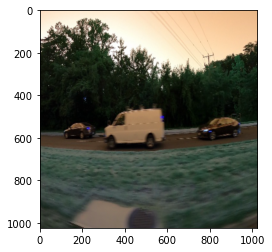

In [37]:
# show the image
plt.imshow(img)
plt.show()

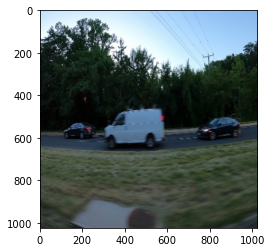

In [38]:
# convert bgr to rgb
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

A three-channel image of variable size - the model does NOT support batching. The input tensor is a tf.uint8 tensor with shape [1, height, width, 3] with values in [0, 255].

In [39]:
# creating tensor and convert to uint8
img_tensor = tf.convert_to_tensor(img, dtype=tf.uint8)

In [40]:
img_tensor.shape

TensorShape([1024, 1024, 3])

In [41]:
# adding extra dimension
img_tensor = tf.expand_dims(img_tensor, 0)
img_tensor.shape

TensorShape([1, 1024, 1024, 3])

### coco labels

In [42]:
import pandas as pd

In [43]:
labels_coco = pd.read_csv('../samples/labels.csv', sep=';', index_col='ID')

In [44]:
labels_coco.head()

,OBJECT (PAPER),OBJECT (2014 REL.),OBJECT (2017 REL.),SUPER CATEGORY
ID,,,,
1,person,person,person,person
2,bicycle,bicycle,bicycle,vehicle
3,car,car,car,vehicle
4,motorcycle,motorcycle,motorcycle,vehicle
5,airplane,airplane,airplane,vehicle


In [45]:
# take only 2017 categories
labels_coco = labels_coco['OBJECT (2017 REL.)']

### model

In [46]:
import tensorflow_hub as hub

In [47]:
# loading detector
detector = hub.load("https://tfhub.dev/tensorflow/efficientdet/d0/1")

In [48]:
# make sample prediction
detector_output = detector(img_tensor)

In [49]:
detector_output.keys()

dict_keys(['detection_anchor_indices', 'detection_boxes', 'detection_classes', 'detection_multiclass_scores', 'detection_scores', 'num_detections', 'raw_detection_boxes', 'raw_detection_scores'])

In [50]:
# Processing outputs
boxes, scores, classes =\
    detector_output['detection_boxes'],\
    detector_output['detection_scores'],\
    detector_output['detection_classes']
pred_labels = classes.numpy().astype('int')[0] 
pred_labels = [labels_coco[i] for i in pred_labels]
#pred_boxes = boxes.numpy()[0].astype('int')
pred_scores = scores.numpy()[0]

In [82]:
# inverse bbox cors vals
pred_boxes = boxes.numpy()[0].copy()
pred_boxes[:,0] = pred_boxes[:,0] * height
pred_boxes[:,1] = pred_boxes[:,1] * width
pred_boxes[:,2] = pred_boxes[:,2] * height
pred_boxes[:,3] = pred_boxes[:,3] * width
pred_boxes = pred_boxes.astype(np.int32)

In [90]:
# copy of an image
img_boxes = img.copy()

In [91]:
# Putting the boxes and labels on the image
how_many_boxes_to_draw = 0
for score, (ymin,xmin,ymax,xmax), label in zip(pred_scores, pred_boxes, pred_labels):
    if score < 0.5:
        continue
    
    score_txt = f'{100 * score}%'
    img_boxes = cv2.rectangle(img_boxes,(xmin, ymax),(xmax, ymin),(0,255,0),2)      
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(img_boxes, label,(xmin, ymax-10), font, 1.5, (255,0,0), 2, cv2.LINE_AA)
    cv2.putText(img_boxes,score_txt,(xmax, ymax-10), font, 1.5, (255,0,0), 2, cv2.LINE_AA)
    
    how_many_boxes_to_draw += 1
    print(f"got it ! | {xmin}, {xmax}, {ymin}, {ymax}, score {score}")
print(f"There is {how_many_boxes_to_draw} boxes")

got it ! | 731, 944, 505, 613, score 0.9030061960220337
got it ! | 109, 264, 526, 607, score 0.8687646985054016
got it ! | 294, 597, 466, 659, score 0.7644354701042175
There is 3 boxes


In [96]:
f'siema {0.1234}'

'siema 0.1234'

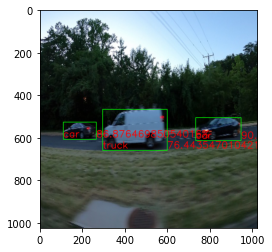

True

In [92]:
plt.imshow(img_boxes)
plt.show()
cv2.imwrite("output.jpg", img_boxes)

## Sources
- https://towardsdatascience.com/object-detection-with-tensorflow-model-and-opencv-d839f3e42849